## Broad Outline

In this assignment, we will implement different types of language models for modeling Indian names. There are clealry patterns in Indian names that models could learn, and we start modeling those using n-gram models, then move to neural n-gram and RNN models.


**Marks Distribution:**
- Unigram: 5
- Bigram: 15
- Trigram: 10
- Neural N-gram LM: 30
- RNN LM: 40



# Read and Preprocess Data

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import math

import random
from collections import Counter, defaultdict

from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

Please note that we may change the contents of the following four files when we rerun your code, so please make sure that your solution is not specifically engineered to just these names.

In [ ]:
# Download the training and validation datasets
!wget -O train_data.csv "https://docs.google.com/spreadsheets/d/1AUzwOQQbAehg_eoAMCcWfwSGhKwSAtnIzapt2wbv0Zs/gviz/tq?tqx=out:csv&sheet=train_data.csv"
!wget -O valid_data.csv "https://docs.google.com/spreadsheets/d/1UtQErvMS-vcQEwjZIjLFnDXlRZPxgO1CU3PF-JYQKvA/gviz/tq?tqx=out:csv&sheet=valid_data.csv"

# Download the text for evaluation
!wget -O eval_prefixes.txt "https://drive.google.com/uc?export=download&id=1tuRLJXLd2VcDaWENr8JTZMcjFlwyRo60"
!wget -O eval_sequences.txt "https://drive.google.com/uc?export=download&id=1kjPAR04UTKmdtV-FJ9SmDlotkt-IKM3b"

--2024-02-25 10:29:39--  https://docs.google.com/spreadsheets/d/1AUzwOQQbAehg_eoAMCcWfwSGhKwSAtnIzapt2wbv0Zs/gviz/tq?tqx=out:csv&sheet=train_data.csv
Resolving docs.google.com (docs.google.com)... 173.194.206.138, 173.194.206.100, 173.194.206.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.206.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘train_data.csv’

train_data.csv          [ <=>                ]  71.07K  --.-KB/s    in 0.01s   

2024-02-25 10:29:39 (4.98 MB/s) - ‘train_data.csv’ saved [72776]

--2024-02-25 10:29:39--  https://docs.google.com/spreadsheets/d/1UtQErvMS-vcQEwjZIjLFnDXlRZPxgO1CU3PF-JYQKvA/gviz/tq?tqx=out:csv&sheet=valid_data.csv
Resolving docs.google.com (docs.google.com)... 173.194.206.138, 173.194.206.100, 173.194.206.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.206.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv

In [ ]:
## Please do not change anything in this code block.

def read_dataframe(ds_type):
    """
    Args:
        ds_type [str] :  dataset type (train or valid)

    Returns:
        df [pandas dataframe]
    """

    df = pd.read_csv(f"/content/{ds_type}_data.csv", header=0, index_col=0)
    df = df[~df['Name'].isna()]
    df['Name'] = df['Name'].astype(str)
    return df

# Load the training and validation datasets
train_data = read_dataframe("train")
validation_data = read_dataframe("valid")

# Read files containing prefixes and character sequences for evaluation
with open('eval_prefixes.txt', 'r') as file:
    eval_prefixes = []
    for line in file:
        eval_prefixes.append(line.strip().split(" "))

with open('eval_sequences.txt', 'r') as file:
    eval_sequences = []
    for line in file:
        eval_sequences.append(line.strip().split(" "))

print(f"Length of training data: {len(train_data)}\nLength of validation data: {len(validation_data)}")

Length of training data: 4539
Length of validation data: 1297


In [ ]:
## Please do not change anything in this code block.

START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens
vocab_from_ascii = True

def build_vocab(names):
    """
    Builds a vocabulary given a list of names

    Args:
        names [list[str]]: list of names

    Returns:
        vocab [torchtext.vocab]: vocabulary based on the names

    """

    if vocab_from_ascii:
        char_counts = {chr(i):i for i in range(128)}
    else:
        char_counts = Counter("".join(names))

    vocab = build_vocab_from_iterator(
                    char_counts,
                    specials=[UNK, START, END], #adding special tokens to the vocabulary
                    min_freq=1
                )
    vocab.set_default_index(vocab[UNK])
    return vocab


def tokenize_name(name):
    """
    Tokenise the name i.e. break a name into list of characters

    Args:
        name [str]: name to be tokenized

    Returns:
        list of characters
    """

    return list(str(name))


def process_data_for_input(data_iter, vocab):
    """
    Processes data for input: Breaks names into characters,
    converts out of vocabulary tokens to UNK and
    appends END token at the end of every name

    Args:
        data_iter: data iterator consisting of names
        vocab: vocabulary

    Returns:
        data_iter [list[list[str]]]: list of names, where each name is a
                                list of characters and is appended with
                                START and END tokens

    """

    vocab_set = set(vocab.get_itos())
    # convert Out Of Vocabulary (OOV) tokens to UNK tokens
    data_iter = [[char if char in vocab_set else UNK
                        for char in tokenize_name(name)] for name in data_iter]
    data_iter = [[START] + name + [END] for name in data_iter]

    return data_iter


def get_tokenised_text_and_vocab(ds_type, vocab=None):
    """
    Reads input data, tokenizes it, builds vocabulary (if unspecified)
    and outputs tokenised list of names (which in turn is a list of characters)

    Args:
        ds_type [str]: Type of the dataset (e.g., train, validation, test)
        vocab [torchtext.vocab]: vocabulary;
                                 If vocab is None, the function will
                                 build the vocabulary from input text.
                                 If vocab is provided, it will tokenize name
                                 according to the vocab, replacing any tokens
                                 not part of the vocab with UNK token.

    Returns:
        data_iter: data iterator for tokenized names
        vocab: vocabulary

    """

    # read the 'Name' column of the dataframe
    if ds_type=='train':
        data_iter = train_data['Name']
    elif ds_type=='valid':
        data_iter = validation_data['Name']
    else:
        data_iter = test_data['Name']

    # build vocab from input data, if vocab is unspecified
    if vocab is None:
        vocab = build_vocab(data_iter)

    # convert OOV chars to UNK, append START and END token to each name
    data_iter = process_data_for_input(data_iter, vocab)

    return data_iter, vocab

Let's look at some examples from the training set

In [ ]:
# Look at some random examples from the training set
examples = ", ".join(random.sample(list(train_data['Name']), 5))
f"Examples from the training set: {examples}"

'Examples from the training set: firtu, japneet, bhhatu, asman, ashman'

# Module 1: N-gram Language Modelling

Load and preprocess the data for n-gram models

In [ ]:
"""choose your hyperparameter and see the difference in performance"""

# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# ADD YOUR CODE HERE

MAX_NAME_LENGTH = 8 # maximum length of names for generation

In [ ]:
# Get data iterator and build vocabulary from input text

train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)

131



Now it's time to implement an [n-gram language model](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

One edge case you will need to handle is that you don't have $n-1$ prior characters at the beginning of the text.  One way to do this is by appending the `START` token $n-1$ times at the start of the name, when implementing an $n$-gram model. You may choose whichever method you like to handle this case as long as you produce a valid probability distribution (one that sums to one).

**Generating names**

To generate from a language model, we can sample one char at a time conditioning on the chars we have generated so far.

In fact there are many strategies to get better-sounding samples, such as only sampling from the top-k chars or sharpening the distribution with a temperature.  You can read more about sampling from a language model in [this](https://arxiv.org/pdf/1904.09751.pdf) paper.


We will now implement N-gram models with $N=1$ (unigram), $N=2$ (bigram), and $N=3$ (trigram).

**Utility Functions**

Implement the utility functions `get_unigram_counts`, `get_bigram_counts` and `get_trigram_counts`. You can use these functions while implementing n-gram models.

In [ ]:
def get_unigram_counts(corpus):
    """
    Given a corpus, calculates the unigram counts for each character in the corpus

    Args:
        corpus [list[list[str]]]: list of tokenized characters. Text is appended with END token.

    Returns:
        unigram_counts [dict [key: char, value: count]]:
            dictionary of unigram counts for each character in the corpus
        Example:
        > unigram_counts["c1"] = 5
    """

    # ADD YOUR CODE HERE

    unigram_counts = dict(Counter([char for name in corpus for char in name]))

    # # taking only alphanumeric characters
    # unigram_counts = {k: v for k, v in unigram_counts.items() if k.isalpha()}

    return unigram_counts

In [ ]:
def get_bigram_counts(corpus):
    """
    Given a corpus, calculates the bigram counts for each bigram in the corpus.
    The corpus *only* contains END tokens at the end of names.
    You may want to handle the case whhere beginning of the name
    does not have n-1 prior chars.

    Args:
        corpus [list[list[str]]]: list of tokenized text. Text is appended with END token.

    Returns:
        bigram_counts [dict[dict]]:
            nested dictionary of bigram counts for each bigram in the corpus
        Example:
        > bigram_counts["c1"]["c2"] = 5
        here bigram_counts["c1"]["c2"] represents P("c2"|"c1")
        P["c1"]["c2"] means P[char_i = "c2"|char_{i-1} = "c1"]
    """

    # ADD YOUR CODE HERE
    bigram_counts = defaultdict(lambda: defaultdict(int))

    for name in corpus:
        for i in range(len(name)-1):
            # if name[i].isalpha() and name[i+1].isalpha():
            bigram_counts[name[i]][name[i+1]] += 1

    return bigram_counts

In [ ]:
def get_trigram_counts(corpus):
    """
    Given a corpus, calculates the trigram counts for each trigram in the corpus.
    The corpus *only* contains END tokens at the end of names.
    You may want to handle the case where beginning of the text
    does not have n-1 prior chars.

    Args:
        corpus [list[list[str]]]: list of tokenized text. Text is appended with END token.

    Returns:
        trigram_counts [dict[dict[dict]]]:
            nested dictionary for each trigram in the corpus
        Example:
        > trigram_counts["c1"]["c2"]["c3"] = 5
        P["c1"]["c2"]["c3] means P[char_i = "c3"|char_{i-2} = "c1", char_{i-1} = "c2"]

    """

    # ADD YOUR CODE HERE
    trigram_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for name in corpus:
        for i in range(len(name)-2):
            #if name[i].isalpha() and name[i+1].isalpha() and name[i+2].isalpha():
            trigram_counts[name[i]][name[i+1]][name[i+2]] += 1

    return trigram_counts

In [ ]:
"""
Implementation of the n-gram language models.
All other n-gram models (unigram, bigram, etc.) would follow the same skeleton.
"""

class NGramLanguageModel(object):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names

        Returns:
            -
        """
        return

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=1 (unigram); dict[key:unigram,value:probability of unigram]
                    > P["c1"] = 0.0001
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["c1"]["c2"] = 0.0001
                    P["c1"]["c2"] means P["c2"|"c1"]
                for N=3 (trigram); dict[dict[dict]]
                    > P["c1"]["c2"]["c3"] = 0.0001
                    P["c1"]["c2"]["c3] means P[char_i = "c3"|char_{i-2} = "c1", char_{i-1} = "c2"]
        """

        return


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the language model

        Args:
            name [list]: list of tokens

        Returns:
            log_prob [float]: Log probability of the given name
        """
        return 0.0


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity [float]: perplexity of the given text
        """
        return 0.0


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.
        You may stop the generation when n tokens have been generated,
        or when you encounter the END token.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            names [list[str]]: list of generated names
        """
        return []

    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        return []

In [ ]:
## Please do not change anything in this code block.

def check_validity(model, ngram, is_neural):
    """
    Checks if get_next_char_probabilities returns a valid probability distribution
    """

    if ngram==1 or is_neural:
        P = model.get_next_char_probabilities()
        is_valid = validate_probability_distribution(P.values())
        if not is_valid:
            return is_valid

    elif ngram==2:
        P = model.get_next_char_probabilities()
        for char1 in P.keys():
            is_valid = validate_probability_distribution(list(P[char1].values()))
            if not is_valid:
                return is_valid

    elif ngram==3:
        P = model.get_next_char_probabilities()
        for char1 in P.keys():
            for char2 in P[char1].keys():
                is_valid = validate_probability_distribution(list(P[char1][char2].values()))
                if not is_valid:
                    return is_valid
    else:
        print("Enter a valid number for ngram")

    return True


def validate_probability_distribution(probs):
    """
    Checks if probs is a valid probability distribution
    """
    if not min(probs) >= 0:
        print("Negative value in probabilities")
        return False
    elif not max(probs) <= 1 + 1e-8:
        print("Value larger than 1 in probabilities")
        return False
    elif not abs(sum(probs)-1) < 1e-4:
        print("probabilities do not sum to 1")
        return False
    return True


def eval_ngram_model(model, ngram, ds, ds_name, eval_prefixes, eval_sequences, num_names=5, is_neural=False):
    """
    Runs the following evaluations on n-gram models:
    (1) checks if probability distribution returned by model.get_next_char_probabilities() sums to one
    (2) checks the perplexity of the model
    (3) generates names using model.generate_names()
    (4) generates names given a prefix using model.generate_names()
    (4) output most likely characters after a given sequence of chars using model.get_most_likely_chars()
    """

    # (1) checks if probability distributions sum to one
    is_valid = check_validity(model=model, ngram=ngram, is_neural=is_neural)

    print(f'EVALUATION probability distribution is valid: {is_valid}')

    # (2) evaluate the perplexity of the model on the dataset
    print(f'EVALUATION of {ngram}-gram on {ds_name} perplexity:',
        model.get_perplexity(ds))

    # (3) generate a few names
    generated_names = ", ".join(model.generate_names(k=num_names))
    print(f'EVALUATION {ngram}-gram generated names are {generated_names}')

    # (4) generate a few names given a prefix
    for prefix in eval_prefixes:
        generated_names_with_prefix = ", ".join(model.generate_names(k=num_names, prefix=prefix))
        prefix = ''.join(prefix)
        print(f'EVALUATION {ngram}-gram generated names with prefix {prefix} are {generated_names_with_prefix}')

    # (5) get most likely characters after a sequence
    for sequence in eval_sequences:
        most_likely_chars = ", ".join(model.get_most_likely_chars(sequence=sequence, k=num_names))
        sequence = "".join(sequence)
        print(f"EVALUATION {ngram}-gram top most likely chars after {sequence} are {most_likely_chars}")

## 1.1 Unigram

In [ ]:
"""
Implementaion of a Unigram Model without smoothing
"""

class UnigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        # ADD YOUR CODE HERE

        # Initialise the train_text
        super().__init__(train_text)
        self.train_text = train_text
        self.unigram_counts = get_unigram_counts(self.train_text)


    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary

        Returns:
            key: char, value: probability
        """

        # ADD YOUR CODE HERE

        # unigram_counts = get_unigram_counts([self.train_text])
        unigram_total = sum(self.unigram_counts.values())
        next_char_probabilities = {char: count/unigram_total for char, count in self.unigram_counts.items()}

        return next_char_probabilities



    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE

        # Get the probabilities of each character if it is in the vocabulary and 0 if it is not
        next_char_probabilities = self.get_next_char_probabilities()
        name_log_probability = sum([np.log(next_char_probabilities[char]) if char in next_char_probabilities else np.log(0) for char in name])

        #name_log_probability = sum([np.log(self.get_next_char_probabilities()[char]) for char in name])

        return name_log_probability



    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        # ADD YOUR CODE HERE

        count = 0

        for name in self.train_text:
            count = count + len(name)

        perplexity = np.exp(-sum([self.get_name_log_probability(name) for name in text])/count)

        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        # ADD YOUR CODE HERE

        names = []
        for _ in range(k):
            name = [START]
            while name[-1] != END and len(name) < n:
                next_char = np.random.choice(list(self.get_next_char_probabilities().keys()), p=list(self.get_next_char_probabilities().values()))
                if next_char != '<s>' and next_char != '</s>':
                    name.append(next_char)
            names.append("".join(name[1:]))

        return names


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        # ADD YOUR CODE HERE

        next_char_probabilities = self.get_next_char_probabilities()
        most_likely_chars = sorted(next_char_probabilities, key=next_char_probabilities.get, reverse=True)[:k]

        return most_likely_chars

### Eval

**Note**: For models without smoothing, you may observe perplexity as `inf` if the validation or test set contains characters not seen in the train set
However, this should not happen for models where you implement smoothing.

In [ ]:
## Please do not change anything in this code block.

unigram_model = UnigramModel(train_text)

# Check the perplexity of the unigram model on the train set
print('unigram train perplexity:',
      unigram_model.get_perplexity(train_text))

unigram train perplexity: 16.623900007096303


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=unigram_model, ngram=1, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 1-gram on validation perplexity: inf
EVALUATION 1-gram generated names are aseeaen, rmmmanr, yalmns&, ujcihna, kneiiar
EVALUATION 1-gram generated names with prefix <s><s>sh are aiarlnd, aatahrr, nhdrmyn, oaulahn, uauipti
EVALUATION 1-gram top most likely chars after <s><s>aa are a, <s>, </s>, i, n


<ipython-input-13-af1115804725>:55: RuntimeWarning: divide by zero encountered in log
  name_log_probability = sum([np.log(next_char_probabilities[char]) if char in next_char_probabilities else np.log(0) for char in name])


### Smoothing

Implement a smoothed version of the unigram model. You may extend the `UnigramModel` class and re-use some of the functions.  For unigram model, you should implement Add-1 smoothing.

You may refer to the lecture slides or [3.5 Smoothing](https://web.stanford.edu/~jurafsky/slp3/3.pdf) for details on different smoothing technqiues.


In [ ]:
"""
Implementation of unigram model with Add-1 smoothing.

"""
class SmoothedUnigramModel(UnigramModel):

    def __init__(self, train_text):
        super().__init__(train_text)

    # You should override ONLY those functions
    # which calculate probability of a unigram.
    # You can override get_next_char_probabilities
    # or any other helper functions you use in UnigramModel
    # to calculate unigram probabilities.

    # Implement Laplace or Add-1 smoothing for the unigram model

    # ADD YOUR CODE HERE

    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary
        with Add-1 smoothing

        Returns:
            key: char, value: probability
        """

        unigram_total = sum(self.unigram_counts.values())
        next_char_probabilities = {char: (count+1)/(unigram_total+len(vocab)) for char, count in self.unigram_counts.items()}
        next_char_probabilities['<unk>'] = 1/(unigram_total+len(vocab))
        next_char_probabilities = {char: prob/sum(next_char_probabilities.values()) for char, prob in next_char_probabilities.items()}

        return next_char_probabilities

    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE

        # Get the probabilities of each character if it is in the vocabulary and 0 if it is not
        next_char_probabilities = self.get_next_char_probabilities()
        name_log_probability = sum([np.log(next_char_probabilities[char]) if char in next_char_probabilities else np.log(next_char_probabilities['<unk>']) for char in name])

        #name_log_probability = sum([np.log(self.get_next_char_probabilities()[char]) for char in name])

        return name_log_probability

In [ ]:
## Please do not change anything in this code block.

smoothed_unigram_model = SmoothedUnigramModel(train_text)

# Check the perplexity of the smoothed unigram model on the train set
print('smoothed unigram train perplexity:',
      smoothed_unigram_model.get_perplexity(train_text))

smoothed unigram train perplexity: 16.62510142141067


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_unigram_model, ngram=1, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences,  num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 1-gram on validation perplexity: 2.5691810370234953
EVALUATION 1-gram generated names are lmsrhum, tyclalj, ylaiulr, hnscdmm, dbpafyd
EVALUATION 1-gram generated names with prefix <s><s>sh are ahirera, nasyana, jluetdm, lpisbip, najriae
EVALUATION 1-gram top most likely chars after <s><s>aa are a, <s>, </s>, i, n


In [ ]:
# Release models we don't need any more.
del unigram_model
del smoothed_unigram_model

## 1.2 Bigram

In [ ]:
"""
Implementation of a Bigram Model.
"""

class BigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        # ADD YOUR CODE HERE

        # Initialise the train_text
        super().__init__(train_text)
        self.bigram_counts = get_bigram_counts(train_text)
        self.train_text = train_text


    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["a"]["b"] = 0.0001 (which stands of P("b"|"a"))
        """

        # ADD YOUR CODE HERE

        bigram_total = {char1: sum(self.bigram_counts[char1].values()) for char1 in self.bigram_counts.keys()}
        next_char_probabilities = {char1: {char2: count/bigram_total[char1] for char2, count in self.bigram_counts[char1].items()} for char1 in self.bigram_counts.keys()}

        return next_char_probabilities


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model.
        Be careful with cases for which probability of the name is zero.

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE

        next_char_probabilities = self.get_next_char_probabilities()
        name_log_probability = sum([np.log(next_char_probabilities[name[i-1]][name[i]]) if name[i-1] in next_char_probabilities and name[i] in next_char_probabilities[name[i-1]] else np.log(0) for i in range(1, len(name))])

        return name_log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        # ADD YOUR CODE HERE

        count = 0

        for name in self.train_text:
            count = count + len(name)

        perplexity = np.exp(-sum([self.get_name_log_probability(name) for name in text])/count)

        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        # ADD YOUR CODE HERE

        names = []
        for _ in range(k):
            name = [START] if prefix is None else prefix.copy()
            while name[-1] != END and len(name) < n:
                next_char = np.random.choice(list(self.get_next_char_probabilities()[name[-1]].keys()), p=list(self.get_next_char_probabilities()[name[-1]].values()))
                if next_char != '<s>' and next_char != '</s>':
                    name.append(next_char)
            if prefix is None:
                names.append("".join(name[1:]))
            else:
                names.append("".join(name[0:]))

        return names


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        # ADD YOUR CODE HERE

        next_char_probabilities = self.get_next_char_probabilities()
        most_likely_chars = sorted(next_char_probabilities[sequence[-1]], key=next_char_probabilities[sequence[-1]].get, reverse=True)[:k]

        return most_likely_chars

### Eval

In [ ]:
## Please do not change anything in this code block.

bigram_model = BigramModel(train_text)

# check the perplexity of the bigram model on training data
print('bigram train perplexity:',
      bigram_model.get_perplexity(train_text))

bigram train perplexity: 7.658283554851139


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=bigram_model, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True


<ipython-input-20-06418783bd74>:57: RuntimeWarning: divide by zero encountered in log
  name_log_probability = sum([np.log(next_char_probabilities[name[i-1]][name[i]]) if name[i-1] in next_char_probabilities and name[i] in next_char_probabilities[name[i-1]] else np.log(0) for i in range(1, len(name))])


EVALUATION of 2-gram on validation perplexity: inf
EVALUATION 2-gram generated names are shayaum, aluemam, ralikha, argeeta, akafana
EVALUATION 2-gram generated names with prefix <s><s>sh are <s><s>shakas, <s><s>shinac, <s><s>shaaja, <s><s>shekoo, <s><s>shalal
EVALUATION 2-gram top most likely chars after <s><s>aa are </s>, n, r, m, l


### Smoothing

Implement a smoothed version of the bigram model. You may extend the `BigramModel` class and re-use some of the functions.

You will implement the following smoothing techniques:
-  Laplace or add-k smoothing
- Interpolation


**Laplace or Add-k smoothing**
- what is the effect of changing `k`?

In [ ]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

BIGRAM_LAPLACE_K = 1 # value of k for add-k or Laplac smoothing in bigram models

In [ ]:
"""
Implementation of a bigram model with laplace or add-k smoothing.

"""

class LaplaceSmoothedBigramModel(BigramModel):
    # This class extends BigramModel.

    def __init__(self, train_text, k):
        super().__init__(train_text)
        self.k = k # specify k for smoothing

    # You should override ONLY those functions
    # which calculate probability of a bigram.
    # You can override get_next_char_probabilities
    # or any other helper functions you use in BigramModel
    # to calculate bigram probabilities.

    # ADD YOUR CODE HERE

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["a"]["b"] = 0.0001 (which stands of P("b"|"a"))
        """

        # ADD YOUR CODE HERE

        bigram_total = {char1: sum(self.bigram_counts[char1].values()) for char1 in self.bigram_counts.keys()}
        next_char_probabilities = {char1: {char2: (count+self.k)/(bigram_total[char1]+self.k*len(vocab)) for char2, count in self.bigram_counts[char1].items()} for char1 in self.bigram_counts.keys()}

        # normalise the probabilities
        next_char_probabilities = {char1: {char2: prob/sum(next_char_probabilities[char1].values()) for char2, prob in next_char_probabilities[char1].items()} for char1 in next_char_probabilities.keys()}

        return next_char_probabilities

    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model.
        Be careful with cases for which probability of the name is zero.

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE

        next_char_probabilities = self.get_next_char_probabilities()
        name_log_probability = sum([np.log(next_char_probabilities[name[i-1]][name[i]]) if name[i-1] in next_char_probabilities and name[i] in next_char_probabilities[name[i-1]] else 0 for i in range(1, len(name))])

        return name_log_probability

In [ ]:
## Please do not change anything in this code block.

smoothed_bigram_model = LaplaceSmoothedBigramModel(train_text, k=BIGRAM_LAPLACE_K)

# check the perplexity of the bigram model on training data
print('smoothed bigram train perplexity:',
      smoothed_bigram_model.get_perplexity(train_text))

smoothed bigram train perplexity: 7.66338530194942


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_bigram_model, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 2-gram on validation perplexity: 1.6528329929509393
EVALUATION 2-gram generated names are ashisaf, mldamaa, mjehuka, gunitar, dhunsha
EVALUATION 2-gram generated names with prefix <s><s>sh are <s><s>shimal, <s><s>shyaen, <s><s>shalda, <s><s>shahal, <s><s>shanam
EVALUATION 2-gram top most likely chars after <s><s>aa are </s>, n, r, m, l


**Interpolation**
- what are good values for `lambdas` in interpolation?

In [ ]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

BIGRAM_LAMBDAS = (0.4, 0.6) # lambdas for interpolation smoothing in bigram models

In [ ]:
"""
Implementation of a bigram model with interpolation smoothing
"""

class InterpolationSmoothedBigramModel(BigramModel):

    def __init__(self, train_text, lambdas):
        super().__init__(train_text)
        self.lambda_1, self.lambda_2 = lambdas
        self.unigram_counts = get_unigram_counts(self.train_text)

    # You should override ONLY those functions
    # which calculate probability of a bigram.
    # You can override get_next_char_probabilities
    # or any other helper functions you use in BigramModel
    # to calculate bigram probabilities.

    # ADD YOUR CODE HERE

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["a"]["b"] = 0.0001 (which stands of P("b"|"a"))
        """

        # ADD YOUR CODE HERE

        bigram_total = {char1: sum(self.bigram_counts[char1].values()) for char1 in self.bigram_counts.keys()}
        next_char_probabilities = {char1: {char2: (self.lambda_1*self.bigram_counts[char1][char2]/bigram_total[char1] + self.lambda_2*self.unigram_counts[char2]/sum(self.unigram_counts.values())) for char2 in self.bigram_counts[char1].keys()} for char1 in self.bigram_counts.keys()}

        # normalise the probabilities
        next_char_probabilities = {char1: {char2: prob/sum(next_char_probabilities[char1].values()) for char2, prob in next_char_probabilities[char1].items()} for char1 in next_char_probabilities.keys()}

        return next_char_probabilities

    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model.
        Be careful with cases for which probability of the name is zero.

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE

        next_char_probabilities = self.get_next_char_probabilities()
        name_log_probability = sum([np.log(next_char_probabilities[name[i-1]][name[i]]) if name[i-1] in next_char_probabilities and name[i] in next_char_probabilities[name[i-1]] else 0 for i in range(1, len(name))])

        return name_log_probability

In [ ]:
## Please do not change anything in this code block.

smoothed_bigram_model = InterpolationSmoothedBigramModel(train_text, lambdas=BIGRAM_LAMBDAS)

# check the perplexity of the bigram model on training data
print('smoothed bigram train perplexity:',
      smoothed_bigram_model.get_perplexity(train_text))

smoothed bigram train perplexity: 8.748174466325166


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_bigram_model, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 2-gram on validation perplexity: 1.7159671877875684
EVALUATION 2-gram generated names are subbsis, shmaiid, alikiin, naataae, mgaauus
EVALUATION 2-gram generated names with prefix <s><s>sh are <s><s>shhain, <s><s>shlhih, <s><s>shynrk, <s><s>shndkh, <s><s>shntut
EVALUATION 2-gram top most likely chars after <s><s>aa are </s>, n, a, r, m


In [ ]:
# Release models we don't need any more.
del bigram_model
del smoothed_bigram_model

## 1.3 Trigram (smoothed)

In [ ]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

TRIGRAM_LAMBDAS = (0.5, 0.3, 0.2) # lambdas for interpolation smoothing in trigram models

In [ ]:
"""
Implementaion of a Trigram Model with interpolation smoothing.
"""

class TrigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        # ADD YOUR CODE HERE

        # Initialise the train_text
        super().__init__(train_text)
        self.trigram_counts = get_trigram_counts(train_text)
        self.train_text = train_text
        self.unigram_counts = get_unigram_counts(self.train_text)
        self.bigram_counts = get_bigram_counts(train_text)
        self.lambda_1, self.lambda_2, self.lambda_3 = TRIGRAM_LAMBDAS


    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=1 (unigram); dict[key:unigram,value:probability of unigram]
                    > P["a"] = 0.0001
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["a"]["b"] = 0.0001 (corresponding to P(b|a))
                for N=3 (trigram); dict[dict[dict]]
                    > P["a"]["b"]["c"] = 0.0001 (corresponding to P(c|ab))
        """

        # ADD YOUR CODE HERE

        trigram_total = {char1: {char2: sum(self.trigram_counts[char1][char2].values()) for char2 in self.trigram_counts[char1].keys()} for char1 in self.trigram_counts.keys()}
        next_char_probabilities = {char1: {char2: {char3: (self.lambda_1*self.trigram_counts[char1][char2][char3]/trigram_total[char1][char2] + self.lambda_2*self.bigram_counts[char2][char3]/sum(self.bigram_counts[char2].values()) + self.lambda_3*self.unigram_counts[char3]/sum(self.unigram_counts.values())) for char3 in self.trigram_counts[char1][char2].keys()} for char2 in self.trigram_counts[char1].keys()} for char1 in self.trigram_counts.keys()}

        # normalise the probabilities
        next_char_probabilities = {char1: {char2: {char3: prob/sum(next_char_probabilities[char1][char2].values()) for char3, prob in next_char_probabilities[char1][char2].items()} for char2, prob in next_char_probabilities[char1].items()} for char1, prob in next_char_probabilities.items()}

        return next_char_probabilities


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model.
        Be careful with cases for which probability of the name is zero.

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE

        next_char_probabilities = self.get_next_char_probabilities()
        name_log_probability = sum([np.log(next_char_probabilities[name[i-2]][name[i-1]][name[i]]) if name[i-2] in next_char_probabilities and name[i-1] in next_char_probabilities[name[i-2]] and name[i] in next_char_probabilities[name[i-2]][name[i-1]] else 0 for i in range(2, len(name))])

        return name_log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        # ADD YOUR CODE HERE

        count = 0

        for name in self.train_text:
            count = count + len(name)

        perplexity = np.exp(-sum([self.get_name_log_probability(name) for name in text])/count)

        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        # ADD YOUR CODE HERE

        names = []

        for _ in range(k):
            name = [START, START] if prefix is None else prefix.copy()
            while name[-1] != END and len(name) < n:
                if prefix is None:
                    a = np.random.choice(list(self.get_next_char_probabilities().keys()))
                    b = np.random.choice(list(self.get_next_char_probabilities()[a].keys()))
                    next_char_probs = self.get_next_char_probabilities()[a][b]
                    next_char = np.random.choice(list(next_char_probs.keys()), p=list(next_char_probs.values()))
                    if next_char != '<s>' and next_char != '</s>':
                        name.append(next_char)
                else:
                    next_char_probs = self.get_next_char_probabilities()[name[-2]][name[-1]]
                    next_char = np.random.choice(list(next_char_probs.keys()), p=list(next_char_probs.values()))
                    if next_char != '<s>' and next_char != '</s>':
                        name.append(next_char)
            if prefix is None:
                names.append("".join(name[2:]))
            else:
                names.append("".join(name[0:]))

        return names

        # names = []
        # for _ in range(k):
        #     name = prefix
        #     while name[-1] != END and len(name) < n:
        #         #name.append(np.random.choice(list(self.get_next_char_probabilities()[name[-2]][name[-1]].keys()), p=list(self.get_next_char_probabilities()[name[-2]][name[-1]].values())))
        #         next_char_probs = self.get_next_char_probabilities()[name[-2]][name[-1]]
        #         next_char = np.random.choice(list(next_char_probs.keys()), p=list(next_char_probs.values()))
        #         name.append(next_char)
        #     names.append("".join(name[1:]))


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        # ADD YOUR CODE HERE

        next_char_probabilities = self.get_next_char_probabilities()
        most_likely_chars = sorted(next_char_probabilities[sequence[-2]][sequence[-1]], key=next_char_probabilities[sequence[-2]][sequence[-1]].get, reverse=True)[:k]

        return most_likely_chars

#### Eval

In [ ]:
## Please do not change anything in this code block.

trigram_model = TrigramModel(train_text)

print('trigram train perplexity:',
      trigram_model.get_perplexity(train_text))

trigram train perplexity: 4.460615866489244


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=trigram_model, ngram=3, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 3-gram on validation perplexity: 1.3842457143115143
EVALUATION 3-gram generated names are ahraha, uikaje, ihahae, eheual, aiahot
EVALUATION 3-gram generated names with prefix <s><s>sh are <s><s>shanka, <s><s>shupam, <s><s>shatad, <s><s>shadma, <s><s>sholoo
EVALUATION 3-gram top most likely chars after <s><s>aa are n, s, </s>, r, m


In [ ]:
# Release models we don't need any more.
del trigram_model

# Module 2: Neural Language Modelling

## 2.1 Neural N-gram Language Model

For this part of the assignment, you should use the GPU (you can do this by changing the runtime of this notebook).

In this section, you will implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` chars and outputs a distribution over the next char.

You will use PyTorch to implement the model.  We've provided a little bit of code to help with the data loading using [PyTorch's data loaders](https://pytorch.org/docs/stable/data.html)

In [ ]:
# Import the necessary libraries

import math
import time
import random
import os, sys
import json
from functools import partial

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
import numpy as np

In [ ]:
## Please do not change anything in this code block.

def collate_ngram(batch, text_pipeline):
    """
    Converts the text in the batch to tokens
    and maps the tokens to indices in the vocab.
    The text in the batch is a list of ngrams
    i.e. if N=3, then text contains 3 tokens in a list
    and batch is a list of such texts.

    Returns:
        batch_input [pytorch tensor]:
            input for n-gram model with size batch_size*(ngram-1)
        batch_output [pytorch tensor]:
            output for n-gram model with size batch_size
    """

    batch_input, batch_output = [], []

    # Process each text in the batch
    for text in batch:
        token_id_sequence = text_pipeline(text)
        # last token is the output, and
        #  pervious ngram-1 tokens are inputs
        output = token_id_sequence.pop()
        input = token_id_sequence
        batch_input.append(input)
        batch_output.append(output)

    # Convert lists to PyTorch tensors and moves to the gpu (if using)
    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    if USE_CUDA:
        batch_input = batch_input.cuda()
        batch_output = batch_output.cuda()

    return batch_input, batch_output


def get_dataloader(input_text, vocab, ngram, batch_size, shuffle):
    """
    Creates a dataloader for the n-gram model which
    takes in a list of list of tokens, appends the START token
    at the starting of each text, and converts text into ngrams.

    Example: For a trigram model, the list of characters are
        ["n", "a", "v", "r"]
    will be converted into lists
        ["n", "a", "v"], ["a", "v", "r"]

    For each ngram, first ngram-1 tokens are input and last token
    is the output. Each token is converted into a index in the vocab.
    The dataloader generates a batch of input, output pairs as
    pytorch tensors.


    Args:
        input_text [list[list[str]]]: list of list of tokens
        vocab [torchtext.vocab]: vocabulary of the corpus
    """

    ngram_sequences = []
    for text in input_text:
        if text[0] == START:
            text = [START]*(N_GRAM_LENGTH-2) + text
        else:
            text = [START]*(N_GRAM_LENGTH-1) + text

        # Create training pairs for each char in the text
        for idx in range(len(text) - ngram + 1):
            ngram_sequence = text[idx : (idx + ngram)]
            ngram_sequences.append(ngram_sequence)

    text_pipeline = lambda x: vocab(x)
    collate_fn = collate_ngram

    # creates a DataLoader for the dataset

    """
    dataloader documentation
    https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
    """

    dataloader = DataLoader(
        ngram_sequences,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
        )
    return dataloader

#### FNN Implementation

**Feed-forward Neural Language Modelling**

Like the n-gram LM, the feedforward neural LM approximates the probability of a char given the entire prior context $P(w_t|w_{1:t−1})$ by approximating based on the $N-1$ previous chars:
$$P(w_t|w_1,...,w_{t−1}) ≈ P(w_t|w_{t−N+1},...,w_{t−1})$$


Implement the FNN LM given in this paper: [Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

The architecture of the FNN can be described by the equation and figure:

$$y = b + W x + U \text t \text a \text n \text h (d + H x)$$

- $x$ is of size $(ngram-1)*m$ where $m$ is the size embedding dimensions
- $y$ is of size $V*1$ where $V$ is the vocabulary size

![FNN_LM](https://drive.google.com/uc?id=1aQhkXjWelHfiBfmBQV3z5TjHFNMtqtzT)


**Some tips**:
- embed the chars with dimension $m$ (example, $60$), then flatten into a single embedding for  $n-1$  chars (with size  $(n-1)*m$ )
- you can use Adam or Stochastic Gradient Descent (SGD) for optimising the cross entropy loss
- If you are using SGD, you may want to use momentum, and a learning rate scheduler
- do early stopping based on validation set loss or perplexity

**Important**: Fix seed as 42 whenever performing any randomized operations, e.g., initializing ML models.

In [ ]:
"""
Implemenation of a PyTorch Module that holds the neural network for your model

"""
class FNN_LM(nn.Module):

    def __init__(self, vocab_size, emb_size, hid_size, ngram):
        super(FNN_LM, self).__init__()
        self.ngram = ngram

        # YOUR CODE HERE

        self.emb_size = emb_size
        self.l1 = nn.Linear((ngram-1)*emb_size,hid_size)
        self.l2 = nn.Linear(hid_size,vocab_size,bias=False)
        self.l3 = nn.Linear((ngram-1)*emb_size,vocab_size)
        self.embedding_layer = nn.Embedding(vocab_size,emb_size)


    def forward(self, chars):
        """
        Args:
            chars: this is a tensor of inputs with shape [batch_size x ngram-1]

        Returns:
            logits: a tensor of log probabilities with shape [batch_size x vocab_size]

        """

        # YOUR CODE HERE

        x = self.embedding_layer(chars)
        X = x.view(-1,(self.ngram-1)*self.emb_size)
        l_1 = torch.tanh(self.l1(X))
        logits = self.l3(X)+self.l2(l_1)

        return logits

**The following is the Trainer class for the FNN LM. Add your code for the `training` and `validation` loops.**

In [ ]:
from re import X
class NeuralNGramTrainer:
    """
    NeuralNGramTrainer wraps FNN_LM to handle training and evaluation.

    """

    # NOTE: you are free to add additional inputs/functions
    # to NeuralNGramTrainer to make training better
    # make sure to define and add it within the input
    # and initialization if you are using any additional inputs
    # for usage in the function

    def __init__(
        self,
        ngram,
        model,
        optimizer,
        criterion,
        train_dataloader,
        valid_dataloader,
        epochs,
        use_cuda,
        vocab,
        model_dir
    ):

        self.ngram = ngram
        self.model = model
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.use_cuda = use_cuda
        self.model_dir = model_dir
        self.loss = {"train": [], "val": []}
        self.vocab = vocab

        self.validity_loss_count = []

        # Move the model to GPU if available
        if self.use_cuda:
            self.model = self.model.cuda()


    def train(self):
        """
        Trains the model with train_dataloader and validates using valid_dataloader

        """
        # You may change the input arguments to this function,
        # but make sure to also change the code wherever this function is called

        # ADD YOUR CODE HERE
        # FOR TRAINING & VALIDATION

        for epoch in range(self.epochs):
            # Training phase
            self.model.train()
            self.epoch_train(self.train_dataloader)

            # Validation phase
            self.model.eval()


            validity_loss = 0
            a = 0
            for batch in self.valid_dataloader:
                loss_cpu_item = 0

                x_batch,y_batch = batch
                with torch.no_grad():
                    y_pred = self.model(x_batch)
                    loss = self.criterion(y_pred,y_batch)
                    loss_cpu_item = loss.detach().clone().cpu().item()

                validity_loss += len(batch)*loss_cpu_item
                a  = a + len(batch)
                validity_loss = validity_loss / a
                self.loss["val"].append(validity_loss)
                self.validity_loss_count.append(len(self.loss["train"])-1)


            # Display results
            self.plot_losses()
            print(f"Epoch {epoch + 1}/{self.epochs}")
            print(f"Train Loss: {self.loss['train'][-1]:.4f}")
            print(f"Validation Loss: {self.loss['val'][-1]:.4f}")

    def epoch_train(self,d):
        for batch in d:
            x_batch,y_batch = batch
            y_pred = self.model(x_batch)
            loss = self.criterion(y_pred,y_batch)
            loss.backward()
            self.loss["train"].append(loss.detach().clone().cpu().item())
            self.optimizer.step()
            if hasattr(self.optimizer,"sched"):self.optimizer.sched.step()
            self.optimizer.zero_grad()




    def plot_losses(self):
        """
        Plots the training and validation losses
        """
        plt.plot(self.loss['train'], label='train_ppl')
        plt.plot(self.validity_loss_count,self.loss['val'], label='val_ppl')
        plt.legend()
        plt.show


    def save_model(self):
        """
        Save final model to directory

        """

        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)


    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """

        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)


    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary
        with a default starting sequence of [START]*(ngram-1)
        Example:
            If ngram=3, then default starting sequence for which
            probabilities have to be returned is
            [START, START]

        Returns:
            dictionary with key: char, value: probability

        """

        # ADD YOUR CODE HERE

        # Creating token_ids for n-gram language model
        start_token_ids = torch.tensor([vocab[c] for c in [START] * (self.ngram - 1)], dtype=torch.long).reshape(1, self.ngram - 1)

        # Move tensor to GPU if applicable
        if self.use_cuda:
            start_token_ids = start_token_ids.cuda()

        # Set the model to evaluation mode and calculate probabilities
        self.model.eval()
        with torch.no_grad():
            probabilities = torch.softmax(self.model(start_token_ids), dim=1)[0]



        # Create a dictionary of next character probabilities
        next_char_probabilities = {vocab.get_itos()[i]: probabilities[i] for i in range(len(probabilities))}


        return next_char_probabilities


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list[str]]
        """

        # ADD YOUR CODE HERE
        # Set the model to evaluation mode
        self.model.eval()

        # If prefix is not provided, initialize it with START tokens
        if prefix is None:
            prefix = [START] * (self.ngram - 1)

        # Ensure the prefix length matches the required n-gram length
        if len(prefix) != self.ngram - 1:
            prefix = [START] * (self.ngram - 1 - len(prefix)) + prefix

        # List to store generated names
        names = []

        # Generate k names
        for i in range(k):
            current_name = prefix.copy()
            name_length = 0

            while name_length < n:
                # Convert current name to token_ids
                token_ids = torch.tensor([vocab[c] for c in current_name[-(self.ngram - 1):]], dtype=torch.long).reshape(1, -1)

                # Move tensor to GPU if applicable
                if self.use_cuda:
                    token_ids = token_ids.cuda()

                # Calculate probabilities and sample the next character
                with torch.no_grad():
                    probabilities = torch.softmax(self.model(token_ids), dim=1)[0].cpu().numpy()
                next_char = vocab.get_itos()[np.random.choice(len(probabilities), p=probabilities)]

                # Break if END token is encountered
                if next_char == END:
                    break

                # Append the next character to the current name
                current_name.append(next_char)
                name_length += 1

            # Add the generated name to the list
            names.append("".join(current_name))




        # don't forget self.model.eval()

        return names


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on text as a float.

        Args:
            text [list[list[str]]]: list of tokenised names
            > Example:
            [['<s>', 'a', 'a', 'b', 'i', 'd', '</s>'],
            ['<s>', 'a', 'a', 'b', 'i', 'd', 'a', '</s>']]

        Returns:
            perplexity [float]

        """

        # ADD YOUR CODE HERE
# Set the model to evaluation mode
        self.model.eval()

        # Create a DataLoader for the text
        data_loader = get_dataloader(text, vocab, self.ngram, 256, False)

        # Initialize variables for entropy calculation
        entropy, n = 0, 0

        # Calculate entropy using the DataLoader
        with torch.no_grad():
            for inputs, targets in data_loader:
                # Forward pass to get logits
                logits = self.model(inputs)

                # Calculate probabilities for the correct predictions
                probabilities = torch.softmax(logits, dim=1)[range(len(inputs)), targets.ravel()]

                # Move probabilities to CPU if applicable
                if self.use_cuda:
                    probabilities = probabilities.cpu()

                # Convert probabilities to numpy array
                probabilities = probabilities.numpy()

                # Update entropy
                entropy -= np.sum(np.log(probabilities))
                n += len(inputs)

        # Calculate average entropy and perplexity
        average_entropy = entropy / n
        perplexity = np.exp(average_entropy)

# Note: You may want to use the DataLoader directly for better efficiency
# Don't forget to set the model back to evaluation mode with self.model.eval()


        return perplexity


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """

        # ADD YOUR CODE HERE

        self.model.eval()

        # Retrieve the index-to-token mapping
        index_to_token = vocab.get_itos()

        # Ensure the sequence length matches the required n-gram length
        if len(sequence) != self.ngram - 1:
            sequence = [START] * (self.ngram - 1 - len(sequence)) + sequence

        # Convert the last n-1 tokens of the sequence to token_ids
        token_ids = torch.tensor([vocab[c] for c in sequence[-(self.ngram - 1):]], dtype=torch.long).reshape(1, -1)

        # Move tensor to GPU if applicable
        if self.use_cuda:
            token_ids = token_ids.cuda()

        # Forward pass to get logits and probabilities
        with torch.no_grad():
            logits = self.model(token_ids)
            probabilities = torch.softmax(logits, dim=1)

            # Move probabilities to CPU if applicable
            if self.use_cuda:
                probabilities = probabilities.cpu()

            # Convert probabilities to numpy array
            probs_array = probabilities.numpy()

        # Sort characters based on probabilities in descending order
        char_prob_pair = sorted(zip(index_to_token, list(probs_array.ravel())), key=lambda x: x[1], reverse=True)

        # Get the top k most likely characters
        most_likely_chars = [c for c, _ in char_prob_pair[:k]]


        # don't forget self.model.eval()

        return most_likely_chars

In [ ]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

MAX_NAME_LENGTH = 7 # maximum length of name for generation

# Remember to fix seed as 42
torch.manual_seed(42)

# check if GPU is available
USE_CUDA = torch.cuda.is_available()
print(f"GPU is available: {USE_CUDA}")

N_GRAM_LENGTH = 5 # The length of the n-gram (N_GRAM_LENGTH=3 for trigram)
EMB_SIZE = 16 # The size of the embedding
HID_SIZE = 64 # The size of the hidden layer
EPOCHS = 15
BATCH_SIZE = 1024
SHUFFLE = True # if dataset should be shuffled

GPU is available: True


In [ ]:
## Please do not change anything in this code block.

# Get data iterator and build vocabulary from input text
train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)

# Load training and validation dataloaders
train_dataloader = get_dataloader(train_text, vocab, ngram = N_GRAM_LENGTH, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valid_dataloader = get_dataloader(validation_text, vocab, ngram = N_GRAM_LENGTH, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

131


Epoch 1/15
Train Loss: 3.5852
Validation Loss: 0.3920
Epoch 2/15
Train Loss: 2.4202
Validation Loss: 0.3257
Epoch 3/15
Train Loss: 2.2432
Validation Loss: 0.2986
Epoch 4/15
Train Loss: 2.2905
Validation Loss: 0.2861
Epoch 5/15
Train Loss: 2.1315
Validation Loss: 0.2667
Epoch 6/15
Train Loss: 2.0612
Validation Loss: 0.3169
Epoch 7/15
Train Loss: 2.1784
Validation Loss: 0.2773
Epoch 8/15
Train Loss: 2.1012
Validation Loss: 0.2735
Epoch 9/15
Train Loss: 2.1225
Validation Loss: 0.2968
Epoch 10/15
Train Loss: 2.1481
Validation Loss: 0.2864
Epoch 11/15
Train Loss: 2.0666
Validation Loss: 0.2883
Epoch 12/15
Train Loss: 1.8790
Validation Loss: 0.2661
Epoch 13/15
Train Loss: 1.7865
Validation Loss: 0.2870
Epoch 14/15
Train Loss: 2.0527
Validation Loss: 0.2803
Epoch 15/15
Train Loss: 2.0389
Validation Loss: 0.2771
Training finished.
Model artifacts saved to folder: Ashhar_Zaman_22881/fnn


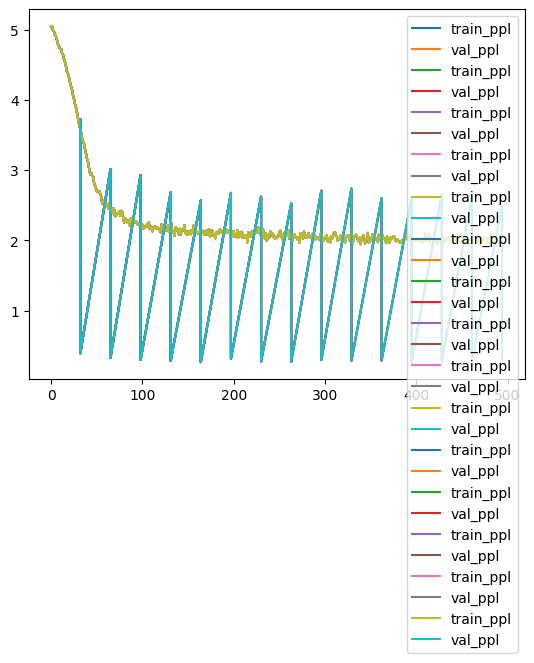

In [ ]:
# ADD YOUR CODE HERE

# This is the part where you should train your FNN_LM model

# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# Initialise the model, optimizer, learning rate scheduler (optional), and loss criteria
model = FNN_LM(vocab_size=vocab_size, emb_size=EMB_SIZE, hid_size=HID_SIZE, ngram=N_GRAM_LENGTH)
# Move the model to GPU if available
if USE_CUDA:
  model = model.cuda()

lr = 0.01
weight_decay = 0.1
optimizer = optim.AdamW(model.parameters(),lr=lr,weight_decay=weight_decay)
optimizer.sched = optim.lr_scheduler.OneCycleLR(optimizer,lr,EPOCHS*len(train_dataloader))
criterion = nn.functional.cross_entropy

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

model_dir = 'Ashhar_Zaman_22881/fnn'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = NeuralNGramTrainer(
        ngram=N_GRAM_LENGTH,
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        epochs=EPOCHS,
        use_cuda=USE_CUDA,
        model_dir=model_dir,
        vocab=vocab)

# Train the model
trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

### Eval

In [ ]:
eval_ngram_model(trainer, ngram=N_GRAM_LENGTH, ds=validation_text, ds_name='valid', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5, is_neural=True)

EVALUATION probability distribution is valid: True
EVALUATION of 5-gram on valid perplexity: 14.105714302256239
EVALUATION 5-gram generated names are <s><s><s><s>faloh, <s><s><s><s>kajana, <s><s><s><s>raima, <s><s><s><s>tamitak, <s><s><s><s>ajisin
EVALUATION 5-gram generated names with prefix <s><s>sh are <s><s>sharjnasai, <s><s>sharindeen, <s><s>shaha, <s><s>sharani, <s><s>shaula
EVALUATION 5-gram top most likely chars after <s><s>aa are s, n, m, r, b


Load your saved model and generate a few names

In [ ]:
START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

folder = 'Ashhar_Zaman_22881/fnn'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the saved model
model = torch.load(f"{folder}/model.pt", map_location=device)
vocab = torch.load(f"{folder}/vocab.pt")

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = NeuralNGramTrainer(
        ngram=N_GRAM_LENGTH,
        model=model,
        optimizer=None,
        criterion=None,
        train_dataloader=None,
        valid_dataloader=None,
        epochs=None,
        use_cuda=USE_CUDA,
        model_dir=None,
        vocab=vocab)

# Generate a few names
names = trainer.generate_names(k=5, n=MAX_NAME_LENGTH, prefix=['a','a','s','h'])
print(", ".join(names))

# you may use this block to test if your model and vocab load properly,
# and that your functions are able to generate sentences, calculate perplexity etc.

aashaniran, aash, aashana, aashilak, aash


In [ ]:
# Release models we don't need any more.
del trainer
del model

## 2.2 Recurrent Neural Networks for Language Modelling

For this stage of the assignment, you will implement an RNN language model.

Some tips:
* use dropout
* use the same weights for the embedding layer and the pre-softmax layer
* train with Adam


In [ ]:
"""
Implemenation of a PyTorch Module that holds the RNN

"""
class RNN_LM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNN_LM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        output = self.fc(output[:, -1])

        return output

In [ ]:
class RNNTrainer:
    """
    RNNTrainer wraps RNN_LM to handle training and evaluation.

    """

    # NOTE: you are free to add additional inputs/functions
    # to RNNTrainer to make training better
    # make sure to define and add it within the input
    # and initialization if you are using any additional inputs
    # for usage in the function

    def __init__(
        self,
        model,
        optimizer,
        criterion,
        train_dataloader,
        valid_dataloader,
        epochs,
        use_cuda,
        vocab,
        model_dir
    ):

        self.model = model
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.use_cuda = use_cuda
        self.model_dir = model_dir
        self.loss = {"train": [], "val": []}
        self.vocab = vocab

        # Move the model to GPU if available
        if self.use_cuda:
            self.model = self.model.cuda()

    def train(self):
        """
        Trains the model with train_dataloader and validates using valid_dataloader

        """
        # You may change the input arguments to this function,
        # but make sure to also change the code wherever this function is called

        # ADD YOUR CODE HERE FOR TRAINING & VALIDATION

        def train(self):
            for epoch in range(self.epochs):
                for inputs, targets in self.train_dataloader:
                    if self.use_cuda:
                        inputs, targets = inputs.cuda(), targets.cuda()

                    self.optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets)
                    loss.backward()
                    self.optimizer.step()

                    self.loss["train"].append(loss.item())

                with torch.no_grad():
                    for inputs, targets in self.valid_dataloader:
                        if self.use_cuda:
                            inputs, targets = inputs.cuda(), targets.cuda()

                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, targets)

                        self.loss["val"].append(loss.item())


    def save_model(self):
        """
        Save final model to directory

        """

        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)


    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """

        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)


    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary
        with a default starting sequence of [START]

        Returns:
            dictionary with key: char, value: probability

        """

        # ADD YOUR CODE HERE

        self.model.eval()
        with torch.no_grad():
            inputs = torch.tensor([self.vocab.get_stoi()['<s>']])
            if self.use_cuda:
                inputs = inputs.cuda()
            outputs = self.model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            next_char_probabilities = {char: prob for char, prob in zip(self.vocab.itos, probabilities.cpu().numpy())}
        return next_char_probabilities


    def generate_names(self, k, n, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list[str]]
        """

        # ADD YOUR CODE HERE

        # don't forget self.model.eval()

        self.model.eval()
        names = []
        with torch.no_grad():
            for _ in range(k):
                name = [self.vocab.stoi['<s>']]
                for _ in range(n):
                    inputs = torch.tensor([name[-1]])
                    if self.use_cuda:
                        inputs = inputs.cuda()
                    outputs = self.model(inputs)
                    probabilities = torch.nn.functional.softmax(outputs, dim=1)
                    next_char = np.random.choice(len(self.vocab), p=probabilities.cpu().numpy())
                    name.append(next_char)
                    if next_char == self.vocab.stoi['</s>']:
                        break
                names.append(''.join(self.vocab.itos[i] for i in name[1:]))
        return names


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on text as a float.

        Args:
            text [list[list[str]]]: list of tokenised names
            > Example:
            [['<s>', 'a', 'a', 'b', 'i', 'd', '</s>'],
            ['<s>', 'a', 'a', 'b', 'i', 'd', 'a', '</s>']]

        Returns:
            perplexity [float]

        """

        # ADD YOUR CODE HERE

        # you may want to use the dataloader here
        # don't forget self.model.eval()

        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for sentence in text:
                inputs = torch.tensor([self.vocab.stoi[char] for char in sentence[:-1]])
                targets = torch.tensor([self.vocab.stoi[char] for char in sentence[1:]])
                if self.use_cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
        perplexity = np.exp(total_loss / len(text))
        return perplexity


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """

        # ADD YOUR CODE HERE

        # don't forget self.model.eval()

        self.model.eval()
        with torch.no_grad():
            inputs = torch.tensor([self.vocab.stoi[char] for char in sequence])
            if self.use_cuda:
                inputs = inputs.cuda()
            outputs = self.model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            topk_probs, topk_indices = torch.topk(probabilities, k)
            most_likely_chars = [self.vocab.itos[i] for i in topk_indices.cpu().numpy()]
        return most_likely_chars

In [ ]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

MAX_NAME_LENGTH = 15 # maximum length of name for generation

# Remember to fix seed as 42
torch.manual_seed(42)

# check if GPU is available
USE_CUDA = torch.cuda.is_available()
print(f"GPU is available: {USE_CUDA}")

EPOCHS = 10
BATCH_SIZE = 64
SHUFFLE = True # if dataset should be shuffled

# Get data iterator and build vocabulary from input text
train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)

# create the dataloaders for training and validation

# ADD YOUR CODE HERE

train_dataloader = DataLoader(train_text, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valid_dataloader = DataLoader(validation_text, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

GPU is available: True
131


In [ ]:
# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# Initialize the model
# you may want to pass arguments to RNN_LM based on your implementation
model = RNN_LM(vocab_size, embedding_dim=128, hidden_dim=256)
# Move the model to GPU if available
if USE_CUDA:
  model = model.cuda()

# Initialise the optimizer, learning rate scheduler (optional), and loss criteria
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

model_dir = 'Ashhar_Zaman_22881/rnn'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = RNNTrainer(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        epochs=EPOCHS,
        use_cuda=USE_CUDA,
        vocab=vocab,
        model_dir=model_dir
        )

# Train the model
trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

Training finished.
Model artifacts saved to folder: Ashhar_Zaman_22881/rnn


### Eval

In [ ]:
## Please do not change anything in this code block.

def eval_rnn_model(model, ds, ds_name, eval_prefixes, eval_sequences, num_names=5):
    """
    Runs the following evaluations on n-gram models:
    (1) checks if probability distribution returned by model.get_next_char_probabilities() sums to one
    (2) checks the perplexity of the model
    (3) generates names using model.generate_names()
    (4) generates names given a prefix using model.generate_names()
    (4) output most likely characters after a given sequence of chars using model.get_most_likely_chars()
    """

    # (1) checks if probability distributions sum to one
    is_valid = check_validity(model, 1, True)
    print(f'EVALUATION probability distribution is valid: {is_valid}')

    # (2) evaluate the perplexity of the model on the dataset
    print(f'EVALUATION of RNN on {ds_name} perplexity:',
        model.get_perplexity(ds))

    # (3) generate a few names
    generated_names = ", ".join(model.generate_names(k=num_names, n=MAX_NAME_LENGTH))
    print(f'EVALUATION RNN generated names are {generated_names}')

    # (4) generate a few names given a prefix
    for prefix in eval_prefixes:
        generated_names_with_prefix = ", ".join(model.generate_names(k=num_names, n=MAX_NAME_LENGTH, prefix=prefix))
        prefix = ''.join(prefix)
        print(f'EVALUATION RNN generated names with prefix {prefix} are {generated_names_with_prefix}')

    # (5) get most likely characters after a sequence
    for sequence in eval_sequences:
        most_likely_chars = ", ".join(model.get_most_likely_chars(sequence=sequence, k=num_names))
        sequence = "".join(sequence)
        print(f"EVALUATION RNN the top most likely chars after {sequence} are {most_likely_chars}")

In [ ]:
eval_rnn_model(trainer, ds=validation_text, ds_name='valid', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 256x131)

In [ ]:
START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

folder = 'Ashhar_Zaman_22881/rnn'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the saved model
model = torch.load(f"{folder}/model.pt", map_location=device)
vocab = torch.load(f"{folder}/vocab.pt")

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = RNNTrainer(
        model=model,
        optimizer=None,
        criterion=None,
        train_dataloader=None,
        valid_dataloader=None,
        epochs=None,
        use_cuda=USE_CUDA,
        model_dir=None,
        vocab=vocab)

# Generate a few names
names = trainer.generate_names(k=5, n=MAX_NAME_LENGTH, prefix=['a','a','s','h'])
print(", ".join(names))

# you may use this block to test if your model and vocab load properly,
# and that your functions are able to generate sentences, calculate perplexity etc.

AttributeError: 'Vocab' object has no attribute 'stoi'

In [ ]:
# Release models we don't need any more.
del trainer
del model